In [1]:
import random
import math
import pprint as pp
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

### Input matrix

The matrix 'input_matrix' is the matrix that represents all the jobs and machine times. 

Each column is a machine and each line is the set of jobs for a given machine.

In [2]:
# Optimal solution is 193
input_matrix = [[34,  2, 54, 61], 
                [15, 89, 70,  9], 
                [38, 19, 28, 87], 
                [95,  7, 34, 29]]

### Function to generate a chromosome. 

It generates a permutation of the given size

In [3]:
def generate_chromo(size):
    return random.sample(range(0, size), size)

### Function to convert a chromosome into a solution (table with scheduling times)

The function receives an chromosome and used the sequence to schedule each task

In [4]:
def chromo_to_solution(chromo, matrix):
    
    num_machines = len(matrix[0])
    
    solution = []
    for i in range(0, num_machines):
        solution.append([{'job': -1, 'start': 0, 'end': 0}])
    
    for index in chromo:
        job     = math.floor(index / len(matrix))
        machine = (index % len(matrix[0]))
        
        start   = solution[machine][-1]['end']
        end     = start + matrix[job][machine]
        flag = True
        while flag:
            flag = False
            for m in range(0, num_machines):
                if m == machine: 
                    continue
                for dic in solution[m]:
                    if dic['job'] == job:
                        if (start < dic['start'] <= end or start < dic['end'] <= end) or (dic['start'] <= start < dic['end'] and dic['start'] <= end < dic['end']):
                            start = dic['end']
                            end   = start + matrix[job][machine]
                            flag  = True

        solution[machine].append({'job' : job, 'start' : start, 'end' : end})
    
    solution = [x[1:] for x in solution]
    
    return solution

### Fitness function

Function to calculate the maximum finishing time for a given solution

In [5]:
def fitness_func(chromo, matrix, verbose=False):
    if chromo == []:
        return 0
    solution = chromo_to_solution(chromo, matrix)
    if verbose == True:
        pp.pprint(solution)
    C = [x[-1]['end'] for x in solution]
    
    return 1/max(C)

### Generate initial population

Given the chromosome size and population size, generates a random population

In [6]:
def generate_initial_population(size_chromo, size_pop=100):
    population = []
    for pop in range(0, size_pop):
        population.append(generate_chromo(size_chromo))
    
    return population

### Mutation

Mutates a chromosome swaping two random positions

In [7]:
def mutation(chromo):
    index1 = random.randrange(len(chromo))
    index2 = random.randrange(len(chromo))
    chromo[index1], chromo[index2] = chromo[index2], chromo[index1]
    return chromo

### Crossover

Function that performs the crossover between two chromosomes

In [8]:
def crossover(chromo1, chromo2):
    chromo = [-1] * len(chromo1)
    chromo2_ext = chromo2 + chromo2
    
    #Possible improvement - sequence goes around chromo
    index1 = random.randrange(len(chromo))
    index2 = random.randrange(index1, len(chromo))
    
    # Copy random sequence
    for index in range(index1, index2+1):
        chromo[index] = chromo1[index]
    
    # Complete last part of chromo
    for index in range(index2 + 1, len(chromo)):
        index_p = index
        while chromo2_ext[index_p] in chromo:
            index_p += 1
            if index_p == len(chromo2_ext):
                break
        chromo[index] = chromo2_ext[index_p]
            
    # Complete first part of chromo
    for index in range(0, index1):
        index_p = index
        while chromo2_ext[index_p] in chromo:
            index_p += 1
            if index_p == len(chromo2_ext):
                break
        chromo[index] = chromo2_ext[index_p]
    
    return chromo
    

### Help function

The following functions perform small tasks to help the genetic algorithm

In [9]:
def find_fittest(population):
    fittest = population[0]
    
    for ind in population:
        if fitness_func(ind, matrix) > fitness_func(fittest, matrix):
            fittest = ind
            
    return ind

In [10]:
def kill_least_fit(population, kill_ratio):
    population = [x for _,x in sorted(zip(list(map(lambda x: fitness_func(x, matrix), population)), population))]
    population.reverse()
    population = population[:math.ceil(len(population) * (1-kill_ratio))]
    
    return population

In [11]:
def generate_ind_crossover(population, prob_array, mutation_prob):
    if np.count_nonzero(prob_array) == 0:
        prob_array = [1] * len(prob_array)
    
    parent1 = -1
    while parent1 == -1:
        index = random.randrange(0, len(prob_array))
        if random.randrange(0, 100) < prob_array[index] * 100:
            parent1 = index
    
    parent2 = -1
    while parent2 == -1:
        index = random.randrange(0, len(prob_array))
        if random.randrange(0, 100) < prob_array[index] * 100:
            parent2 = index
    
    chromo = crossover(population[parent1], population[parent2])
    
    if random.randrange(0, 100) < mutation_prob * 100:
        chromo = mutation(chromo)
    
    return chromo

In [12]:
def generate_offspring(population, population_size, mutation_prob, matrix):
    fitness_array = list(map(lambda x: fitness_func(x, matrix), population))
    fitness_array = np.array(fitness_array)
    scaler = MinMaxScaler()
    prob_array = scaler.fit_transform(fitness_array.reshape(-1,1))
    while len(population) < population_size:
        new_ind = generate_ind_crossover(population, prob_array, mutation_prob)
        population.append(new_ind)
    
    return population

In [13]:
# https://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console
# Function to define the progss bar
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

## Parameters

In [14]:
matrix          = input_matrix
chromo_size     = len(matrix) * len(matrix[0])
population_size = 1000
mutation_prob   = 0.05
kill_pop_ratio  = 0.5
max_iter        = 100

## Genetic algorithm

The algorithm works as follow:
+ Generates a random initial solution
+ Executes 'max_iter' iterations
+ At each iteration it kills 'kill_pop_ratio' of the population
+ It generates new individuals until the population is complete

In [16]:
def genetic_algo():
    cur_iter      = 1
    best_solution = []
    history       = []
    population    = generate_initial_population(chromo_size, population_size)
    
    printProgressBar(0, max_iter, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
    while cur_iter < max_iter:
        best_gen      = find_fittest(population)
        if fitness_func(best_gen, matrix) > fitness_func(best_solution, matrix):
            best_solution = best_gen
        population    = kill_least_fit(population, kill_pop_ratio)
        population    = generate_offspring(population, population_size, mutation_prob, matrix)
        
        
        history.append([1/fitness_func(best_solution, matrix), 1/fitness_func(best_gen, matrix)])
        cur_iter += 1
        printProgressBar(cur_iter, max_iter, prefix = 'Progress:', suffix = 'Complete', length = 50)
    
    return best_solution, history

## Run the algorithm and show the result

In [17]:
best_sol, history = genetic_algo()
print("Chromosome: ", best_sol)
print("Cost: ", 1/fitness_func(best_sol, matrix))
print("Solution: ")
pp.pprint(chromo_to_solution(best_sol, matrix))

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Chromosome:  [5, 14, 11, 0, 2, 12, 8, 6, 9, 3, 15, 10, 13, 4, 1, 7]
Cost:  195.0
[[{'end': 34, 'job': 0, 'start': 0},
  {'end': 129, 'job': 3, 'start': 34},
  {'end': 167, 'job': 2, 'start': 129},
  {'end': 182, 'job': 1, 'start': 167}],
 [{'end': 89, 'job': 1, 'start': 0},
  {'end': 108, 'job': 2, 'start': 89},
  {'end': 136, 'job': 3, 'start': 129},
  {'end': 151, 'job': 0, 'start': 149}],
 [{'end': 34, 'job': 3, 'start': 0},
  {'end': 88, 'job': 0, 'start': 34},
  {'end': 159, 'job': 1, 'start': 89},
  {'end': 195, 'job': 2, 'start': 167}],
 [{'end': 87, 'job': 2, 'start': 0},
  {'end': 149, 'job': 0, 'start': 88},
  {'end': 178, 'job': 3, 'start': 149},
  {'end': 191, 'job': 1, 'start': 182}]]


## Plot best solution over time and best solution for each generation

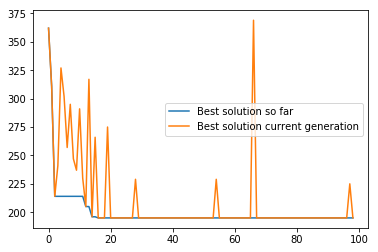

In [22]:
plt.plot(range(0, len(history)), [x[0] for x in history])
plt.plot(range(0, len(history)), [x[1] for x in history])
plt.legend(['Best solution so far', 'Best solution current generation'])
plt.show()